#Building Deep Convolutional Neural Net Classification Model to classify images of children vs adults

## 1- Importing the libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches

## 2- Getting the files and directories 

In [ ]:
!unzip child_vs_adult.zip

In [6]:


PATH = 'child_vs_adult'

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_test = len(os.listdir(test_dir))

print(total_train, total_test)
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

680 2


## 3-Image Preprocessing 

DEFINE A FUNCTION THAT read / decode the images and convert them into floating point tensors.

In [8]:
#defining our image generator functions, we are going to rescale every image
# by dividing each pixel by 255

train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

setting up the image data generators 

In [28]:
train_data_gen = train_image_generator.flow_from_directory(
        directory = train_dir,
        target_size=((IMG_HEIGHT, IMG_WIDTH)),
        batch_size= batch_size,
        class_mode='binary',    
        shuffle=True,
)

test_data_gen = test_image_generator.flow_from_directory(
       directory = test_dir,
       
        target_size=((IMG_HEIGHT, IMG_WIDTH)),
        batch_size=1,
        class_mode = 'binary',
        #classes=[''],
        
        shuffle=False,
        
)

Found 680 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


Lets have a look at some of the images in the dataset 

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% adult")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% child")
    plt.show()

#choose five random images from train_data_gen
sample_training_images, _ = next(train_data_gen)
print(_[:5])
print(train_data_gen.class_indices)
plotImages(sample_training_images[:5])

get augmented images to increase the training sample size 

In [32]:
# 5
train_image_generator = ImageDataGenerator(
    rescale= 1./255,
    #Random transformations
    rotation_range=20, #1
    width_shift_range=0.2, #2
    height_shift_range=0.2, #3
    horizontal_flip=True, #4
    vertical_flip = True, #5,
    fill_mode='nearest',
    shear_range=0.2, #6
    zoom_range=0.2 #7
              
)

Found 680 images belonging to 2 classes.


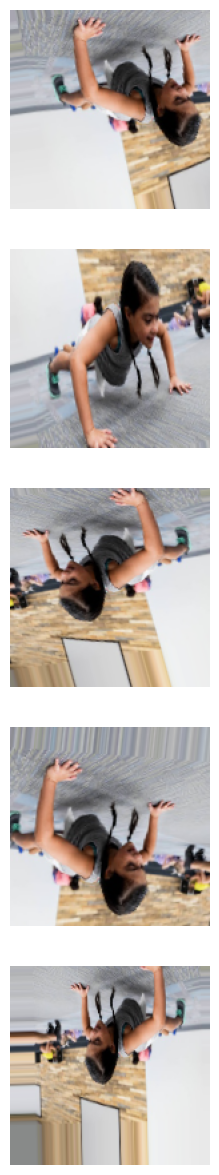

In [33]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Remember that train_data_gen returns float32 tensors of shape (batch_size, image_size[0], image_size[1], num_channels)


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
#the number passed to range will determine how many transformations of the image is returned 

plotImages(augmented_images)


## 4- Building the model 

Instead of building a whole new model from scratchm I will use MobileNetV2 as the base of my model.

MobileNetV2 is a very effective feature extractor for object detection and segmentation. You can read more about it [here](https://keras.io/api/applications/mobilenet/)

In [34]:
# step1 instantiate a base model with pre-trained weights.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150,150,3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
)
#step 2  freeze the base model
base_model.trainable = False
last_output = base_model.output



9406464/9406464 [==============================] - 0s 0us/step


In [35]:
print(last_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")


add a new layer 

In [37]:
def transfer_learning(last_output, pre_trained_model):
    # Flatten the output layer to 1 dimension
    x = tf.keras.layers.Flatten()(last_output)
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.6
    x = tf.keras.layers.Dropout(0.6)(x)  
    # Add a final sigmoid layer for classification
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)          
    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    return model

model = transfer_learning(last_output, base_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

Tune the learning rate

In [38]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [39]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [40]:
lr_history = model.fit(train_data_gen,
                       epochs=60,
                       validation_data=test_data_gen,
                       callbacks=lr_schedule,
                       verbose=0)

lets define a function to plot the learning history 

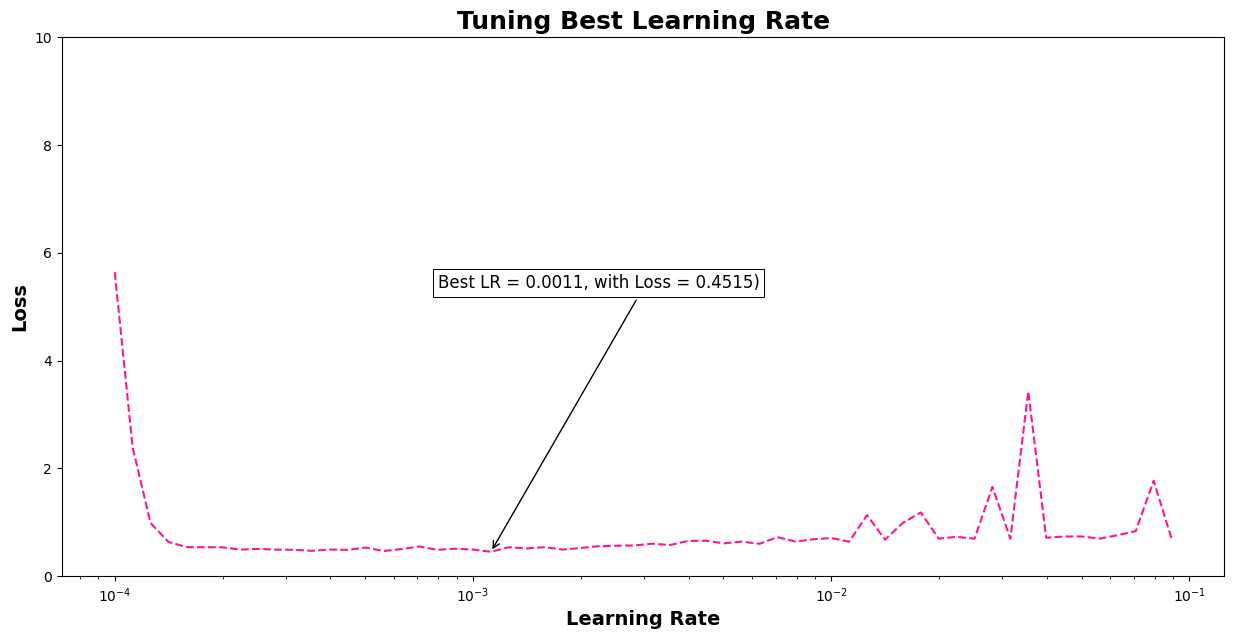

best learn rate = 0.0011220184387639165


In [41]:
def plot_best_learning(lr_history):
    x = lr_history.history["lr"] ; y = lr_history.history["loss"]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    def annot_min(x,y, ax=None):
        xmin = x[np.argmin(y)]
        ymin = np.min(y)
        text= f"Best LR = {xmin:.4f}, with Loss = {ymin:.4f})"
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmin, ymin), xytext=(0.6,0.56), fontsize=12, **kw)
        return xmin
    xmin = annot_min(x,y,ax)
    ax.semilogx(x, y,ls='dashed', color='deeppink')
    ax.set_title('Tuning Best Learning Rate',fontsize=18, fontweight='bold')
    ax.set_ylabel('Loss',fontsize=14, fontweight='bold')
    ax.set_xlabel('Learning Rate',fontsize=14, fontweight='bold')
    plt.ylim((0, 10))
    plt.show()
    return xmin

best_learn_rate = plot_best_learning(lr_history)
print(f"best learn rate = {best_learn_rate}")

## 5-Training our model with the best calibrated Learning Rate

In [42]:
model = transfer_learning(last_output, base_model)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = best_learn_rate),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [43]:
# Define a Callback class that stops training once accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

history = model.fit(train_data_gen,
                    epochs=20,
                    validation_data=test_data_gen,
                    callbacks=callbacks)

Epoch 1/20
6/6 [==============================] - 34s 5s/step - loss: 31.7725 - accuracy: 0.5206 - val_loss: 15.6317 - val_accuracy: 0.5083
Epoch 2/20
6/6 [==============================] - 31s 5s/step - loss: 9.2729 - accuracy: 0.6029 - val_loss: 13.4186 - val_accuracy: 0.5333
Epoch 3/20
6/6 [==============================] - 31s 5s/step - loss: 7.0572 - accuracy: 0.6441 - val_loss: 3.9765 - val_accuracy: 0.7583
Epoch 4/20
6/6 [==============================] - 31s 5s/step - loss: 3.0773 - accuracy: 0.7309 - val_loss: 3.8332 - val_accuracy: 0.7417
Epoch 5/20
6/6 [==============================] - 30s 5s/step - loss: 2.6076 - accuracy: 0.7279 - val_loss: 2.5698 - val_accuracy: 0.7333
Epoch 6/20
6/6 [==============================] - 30s 5s/step - loss: 2.1628 - accuracy: 0.7368 - val_loss: 1.8062 - val_accuracy: 0.7167
Epoch 7/20
6/6 [==============================] - 37s 6s/step - loss: 1.2341 - accuracy: 0.7559 - val_loss: 1.2641 - val_accuracy: 0.7417
Epoch 8/20
6/6 [===============

## 6- A look at our model performance 
    

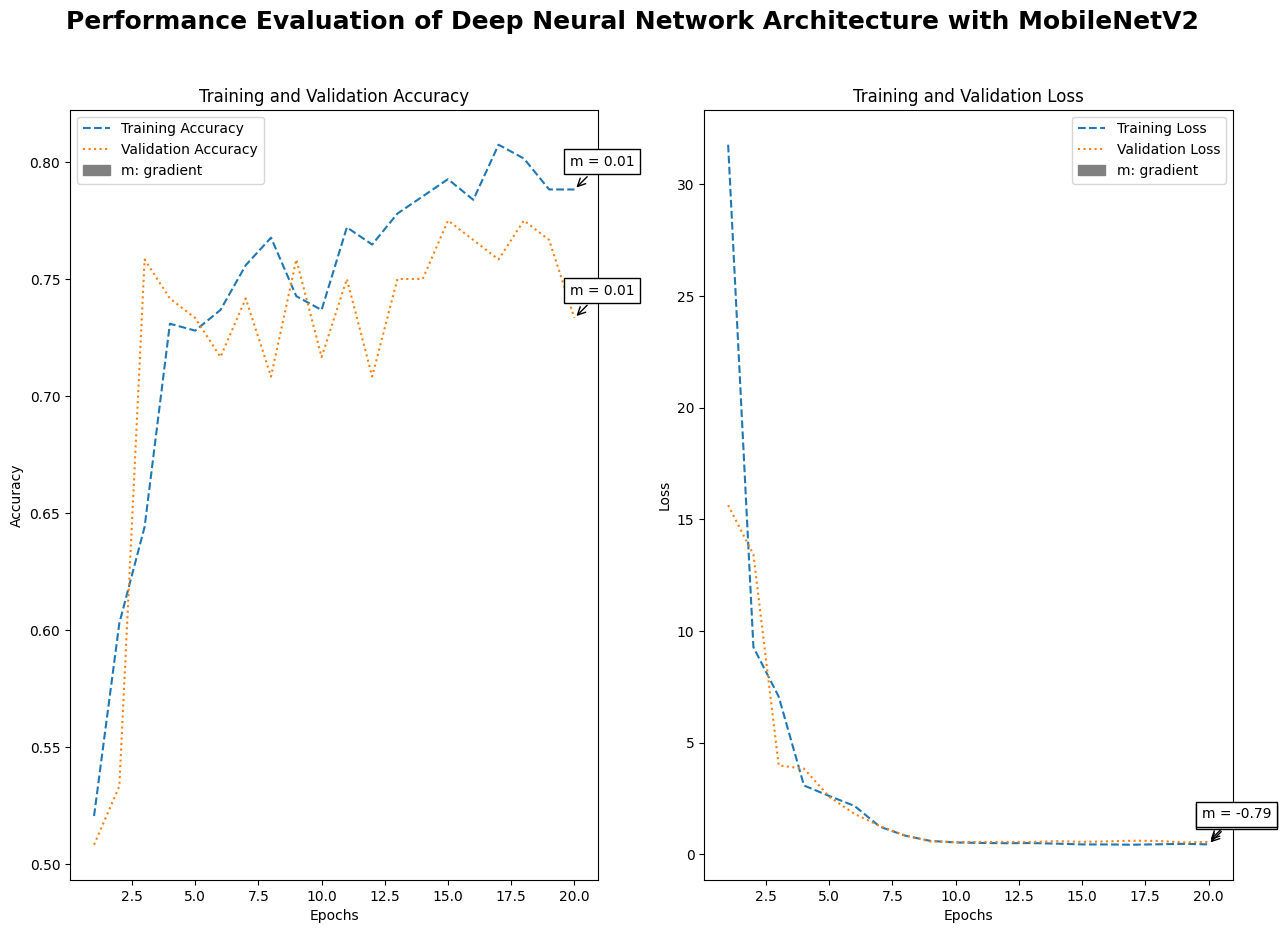

In [44]:
def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    epochs = range(1, len(history_dict['accuracy'])+1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]),2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey',label='m: gradient')
        handles.append(m_patch) 
        axs[n].legend(handles=handles)
        
        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)
    
    plt.suptitle(f"Performance Evaluation of {model_name}",fontsize=18, fontweight='bold')
    plt.show()
    
history_dict = history.history
vis_evaluation(history_dict, 'Deep Neural Network Architecture with MobileNetV2')

## 7- Lets make some predictions 

In [ ]:
def prediction_(YOUR_IMAGE_PATH = None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = '/content/child_vs_adult/test/children/45.jpg' 
    
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])

    class_name = train_data_gen.class_indices
    class_name_inverted = {y: x for x, y in class_name.items()}

    if classes[0]>0.5:
        print(f" This image most likely belongs to '{class_name_inverted[1]}' with a {100 * np.max(score):.2f} percent confidence.")
    else:
        print(f" This image most likely belongs to '{class_name_inverted[0]}' with a {100 * np.max(score):.2f} percent confidence.")




1/1 [==============================] - 0s 64ms/step
 This image most likely belongs to 'adults' with a 55.87 percent confidence.


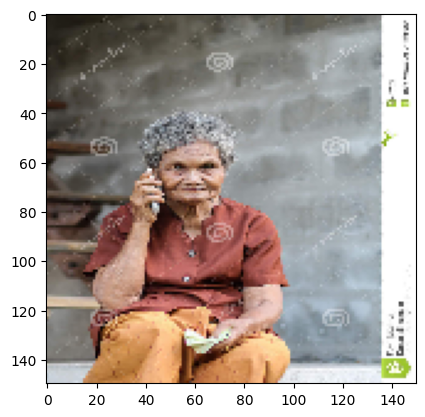

In [54]:
path1 = '/content/adult_woman3.jpg'
path2 = '/content/child2.jpg'
prediction_(YOUR_IMAGE_PATH = path1)


## 8- Conclusion

You can download some jpeg images online and use the **predictions_()**
function to test the model accuracy yourself

**With love 💓 by Lewis Agbognihoue**